# Предиктор результатов футбольных матчей

In [32]:
#importing
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearnex import patch_sklearn # эти строки должны идти перед импортом sklearn
patch_sklearn()                     # для ускорения работы

from sklearn.model_selection    import train_test_split, StratifiedGroupKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics            import accuracy_score, roc_auc_score, RocCurveDisplay, auc, roc_curve
from sklearn.linear_model       import LogisticRegression
from sklearn.preprocessing      import LabelBinarizer
from sklearn.tree               import DecisionTreeClassifier
from sklearn.ensemble           import RandomForestClassifier
from sklearn.inspection         import permutation_importance

from itertools import cycle

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Обзор данных

In [3]:
data = pd.read_csv("data.csv").drop(['odds_open_tm25', 'odds_open_tb25'], axis=1)
data.head()

,idmatch,odds_open_win1,odds_open_draw,odds_open_win2,vi_win_home,vi_win_away,vi_nolose_home,vi_nolose_away,vi_over25_home,vi_over25_away,...,team2_away_xgpower_03_draw_xga90index,team2_away_xgpower_03_draw_xgsubxgaindex,team2_away_xgpower_03_cop_xg90index,team2_away_xgpower_03_cop_xga90index,team2_away_xgpower_03_cop_xgsubxgaindex,team2_away_xgpower_03_com_xg90index,team2_away_xgpower_03_com_xga90index,team2_away_xgpower_03_com_xgsubxgaindex,result_finish_match,result_total_match
0,39231,2.53,3.15,3.02,2.255,-4.318,19.259,-3.855,-41.798,-10.410,...,0.98,0.40,2.13,4.88,0.44,0.55,2.79,0.20,2.0,0.0
1,39232,2.16,3.26,3.66,-13.230,-29.496,4.164,-47.122,-43.926,-4.662,...,1.23,0.36,0.00,0.00,0.00,0.51,1.34,0.38,1.0,0.0
2,39233,2.35,3.16,3.31,-35.270,-1.048,-17.721,-2.781,8.467,-6.808,...,0.87,0.31,0.00,0.17,0.00,0.00,0.00,0.00,3.0,1.0
3,39235,2.50,3.25,2.97,17.593,27.970,1.079,10.260,-27.452,-23.279,...,1.99,0.05,0.00,0.00,0.00,0.18,0.80,0.22,3.0,1.0
4,45425,2.15,3.49,3.46,19.656,-22.231,-8.999,-8.685,7.560,-7.321,...,0.64,1.45,3.35,1.40,2.40,0.73,2.48,0.29,1.0,1.0


In [4]:

with open("raw_data_info.txt", mode='w') as df_info:
    data.info(verbose=True, show_counts=True, buf=df_info)
print('\nБаланс классов\n')
print(data['result_finish_match'].value_counts(), '\n')
print(data['result_total_match'].value_counts())



Баланс классов

1.0    24763
3.0    17585
2.0    15099
Name: result_finish_match, dtype: int64 

0.0    29307
1.0    28140
Name: result_total_match, dtype: int64


Классы более или менее сбалансированны.

## Предобработка

Оставим для обучения и теста только данные, удовлетворяющие условию `selection` (см. код ниже).  Nan-строки долой. На тест выделяем 20% данных, остальное -- обучение.

Увеличим обучающий датасет вдвое, продублировав все строки таким образом, чтобы столбцы, отвечающие за одни и те же параметры для разных команд, поменялись местами. У одинаковых матчей одинаковые id, поэтому для кросс-валидации используем GroupKFold, чтобы никакие два матча не попали одновременно в обучающую и валидационную выборки.

In [5]:
# Для решения задачи пригодными считаем лишь данные, для которых коэффициенты "odds_open_win2" > 2.0 и "odds_open_win1" > 2.0
selection = (data["odds_open_win2"] > 2.0) & (data["odds_open_win1"] > 2.0)

data_selected = data[selection].dropna()
data_selected.shape

(29410, 622)

In [6]:
# Делим на трейн и тест
y_finish = data_selected['result_finish_match'].astype(int)
y_result = data_selected['result_total_match'].astype(int) # на это пока не смотрим
X = data_selected.drop(['result_finish_match', 'result_total_match'], axis=1)
X.iloc[1:, :].astype('float32', copy=False)

X_train, X_test, y_train, y_test = train_test_split(X, y_finish, test_size=0.2, random_state=42, shuffle=True, stratify=y_finish)

In [7]:
# Дублируем данные и переставляем местами пары столбцы следующих видов: 
# "...-2" и "...", 
# "team1..." и "team2...", 
# "...win1" и "...win2" 

def swap(feature_name_1, feature_names_2, train_copy):
    X_train_copy[feature_name_1], X_train_copy[feature_names_2] = X_train_copy[feature_names_2], X_train_copy[feature_name_1]


X_train_copy = X_train.copy(deep=True)
swap('odds_open_win1', 'odds_open_win2', X_train_copy)

for name_2 in X_train_copy.filter(like="-2").columns:  # колонки с паттерном "-2"
    name_1 = ''.join(name_2.split("-2"))  # композиция split и join выделяет из строки подстроку без "-2"
    swap(name_1, name_2, X_train_copy)

for name_2 in X_train_copy.filter(like="team2").columns:  # колонки с паттерном "team2"
    tmp = ''.join(name_2.split("team2"))
    name_1 = 'team1' + tmp  # композиция split и join выделяет из строки подстроку без "team2", слева приписывается "team1"
    swap(name_1, name_2, X_train_copy)


X_train = pd.concat((X_train, X_train_copy))
y_train = pd.concat((y_train, y_train))

In [8]:
groups_train, groups_test = X_train['idmatch'], X_test['idmatch']
X_train.drop('idmatch', axis=1, inplace=True)
X_test.drop('idmatch', axis=1, inplace=True)

X_train.shape, y_train.shape

((47056, 619), (47056,))

In [9]:
# для визуализации результатов сделаем бинаризацию классов: 
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

(5882, 3)

## Вспомогательные функции

In [37]:
def find_best_model(model, X_train, y_train, groups_train, params_grid, scoring, n_iter=0):
    """
    Функция подбора гиперпараметров
    """

    if n_iter:
        search = RandomizedSearchCV(
            model, params_grid, n_iter=n_iter,
            scoring=scoring,
            cv=StratifiedGroupKFold(n_splits=5),
            n_jobs=-1
        )
    else:
        search = GridSearchCV(
        model, params_grid,
        scoring=scoring,
        cv=StratifiedGroupKFold(n_splits=5),
        n_jobs=-1
        )

    search.fit(X_train, y_train, groups=groups_train)

    # Print the best hyperparameters
    print("Best hyperparameters:", search.best_params_)

    # Print the best score
    print("Best cross-val score:", search.best_score_)

    return search.best_estimator_


def display_roc_curves(probas, auc, target_names):
    """
    Отображает микро-усреднённую ROC кривую, а так же ROC-кривые по каждому из классов
    :probas: предсказанные вероятности классов
    :auc: Area Under the Curve ROC (macro)
    :target_names: имена классов
    """

    fig, ax = plt.subplots(figsize=(6, 6))

    fpr_micro, tpr_micro, _ = roc_curve(y_onehot_test.ravel(), probas.ravel())
    plt.plot(
        fpr_micro,
        tpr_micro,
        label=f"micro-average ROC curve (AUC = {auc:.2f})",
        color='m',
        linestyle=":",
        linewidth=3,
    )

    n_classes = probas.shape[1]
    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for class_id, color in zip(range(n_classes), colors):
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            probas[:, class_id],
            name=f"ROC curve for {target_names[class_id]}",
            color=color,
            ax=ax,
            plot_chance_level=(class_id == 2),
        )

    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
    plt.legend()
    plt.grid()
    plt.show()


def test(estimator, name, X_test, y_test, groups_test):
    """
    Прогоняет обученную модель по тестовой выборке и сохраняет результаты в файл с именем "name_results.csv" 
    в виде таблицы со столбцами: idmatch, истинные классы, предсказания, коэффициенты уверенности (3 столбца), вер-ть победы 1, вер-ть ничьей, вер-ть победы 2, 
    а также сохраняет саму модель.
    """

    y_pred = estimator.predict(X_test)
    probas = estimator.predict_proba(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc  = roc_auc_score(y_test, probas, average='micro', multi_class='ovr')

    print("Accuracy: ", accuracy)
    print("ROC AUC (macro):  ", roc_auc)

    table = pd.DataFrame({
        'result_finish_match': y_test,
        'result_finish_match_prediction': y_pred,
        'proba_win_1': probas[:, 0],
        'proba_draw': probas[:, 1],
        'proba_win_2': probas[:, 2]
        }, index=groups_test)
    
    # table.to_csv(name + '_results.csv')

    display_roc_curves(probas, roc_auc, ('win_1', 'draw', 'win_2'))

    return table
    

## Логистическая регрессия

Логистическая регрессия (метрика accuracy)
Best hyperparameters: {'C': 3.359818286283781e-05}
Best cross-val score: 0.37249256261253116
Accuracy:  0.370452227133628
ROC AUC (macro):   0.5388790090411205


c:\Users\Artyom\anaconda3\envs\general_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


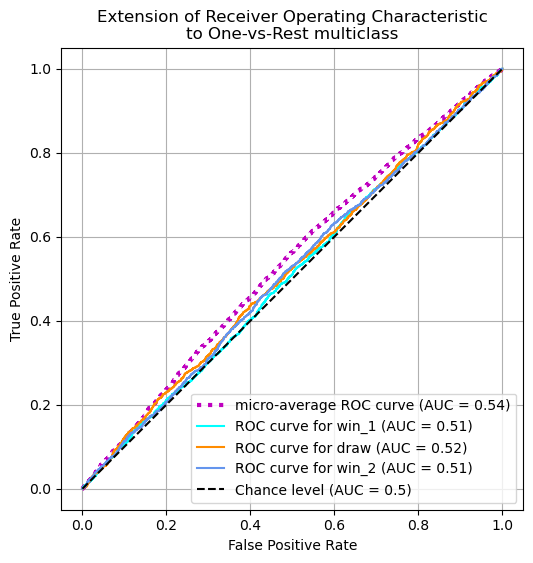

In [29]:
log_reg = LogisticRegression(
    penalty='l2',
    solver='newton-cholesky',
    n_jobs=-1
)

params = {"C": np.logspace(-5, 5, 20)}

print("Логистическая регрессия (метрика accuracy)")
log_reg_best = find_best_model(log_reg, X_train, y_train, groups_train, params, scoring='accuracy')

log_reg_results = test(log_reg_best, 'logistic_1', X_test, y_test, groups_test)

**Вывод:** модель едва лучше рандомайзера.

## Решающее дерево

In [38]:
params = {
    'max_depth': range(10, 52, 3),
    'min_samples_split' : range(10, 500, 20)
}

tree = DecisionTreeClassifier(random_state=42)

print("Решающее дерево (метрика accuracy)")
tree_best = find_best_model(tree, X_train, y_train, groups_train, params, scoring='accuracy')

Решающее дерево (метрика accuracy)
Best hyperparameters: {'max_depth': 10, 'min_samples_split': 410}
Best cross-val score: 0.36322668764128613


Accuracy:  0.36552193131587896
ROC AUC (macro):   0.5447430024992251


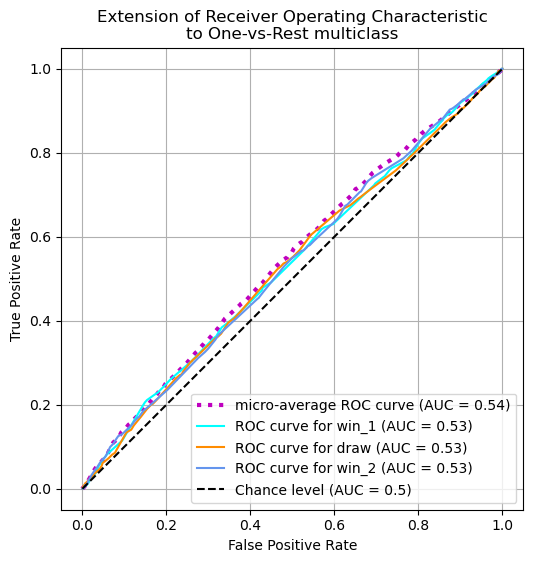

In [39]:
tree_results = test(tree_best, 'tree_1', X_test, y_test, groups_test)

## Случайный лес

In [40]:
forest = RandomForestClassifier(
    n_estimators=300, bootstrap=False,
    n_jobs=-1, max_features='log2',
    warm_start=True, random_state=42
)

forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_features='log2', n_estimators=300,
                       n_jobs=-1, random_state=42, warm_start=True)

Accuracy:  0.379632777966678
ROC AUC (macro):   0.5502965221265876


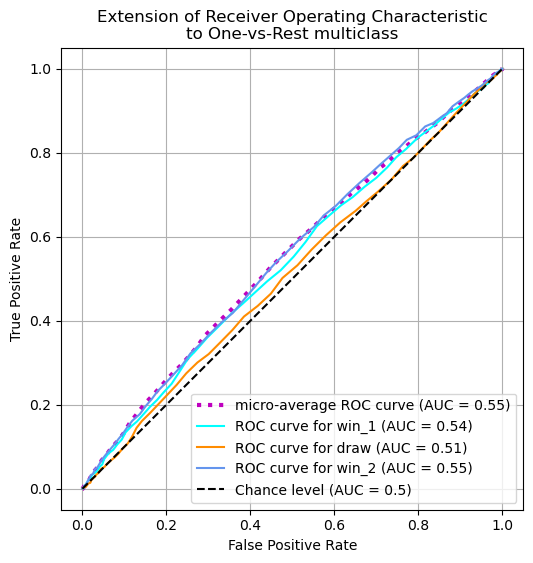

In [41]:
forest_results = test(forest, 'forest_1', X_test, y_test, groups_test)

Важности признаков в модели случайного леса.

In [75]:
def visualize_feature_importances(importances_mean, importances_std, model_name):

    max = importances_mean.max()

    model_importances = pd.Series(importances_mean, index=X_test.columns)

    fig, ax = plt.subplots(figsize=(17, 5))
    model_importances.plot.bar(yerr=importances_std, ax=ax)
    ax.set_title(model_name)
    ax.set_ylabel(f"Mean accuracy decrease")
    fig.tight_layout()
    plt.show()

In [66]:
importances_mean = perm_imps_forest.importances_mean
max = importances_mean.max()
importances_mean[np.abs(importances_mean) > 0.5 * max]

array([-0.00224413, -0.00282217, -0.00210813,  0.00231214,  0.00255015,
       -0.00214213, -0.00227814,  0.00414825, -0.00224413, -0.00299218,
       -0.00292418, -0.00221013, -0.00289017, -0.00227814,  0.00214213,
       -0.00238014, -0.00214213, -0.00238014,  0.00217613, -0.00248215,
       -0.00255015, -0.00261816, -0.00210813, -0.00217613, -0.00210813,
        0.00251615, -0.00231214, -0.00251615, -0.00251615, -0.00258416,
       -0.00425026,  0.00221013,  0.00214213, -0.00234614, -0.00278817,
       -0.00214213, -0.00248215, -0.00234614, -0.00275417,  0.00255015,
       -0.00384223,  0.00221013, -0.00251615, -0.00238014, -0.00285617,
       -0.00278817, -0.00210813, -0.00221013, -0.00278817, -0.00285617])

In [ ]:
perm_imps_forest = permutation_importance(
    forest, X_test, y_test, n_repeats=5, random_state=43, n_jobs=-1
)

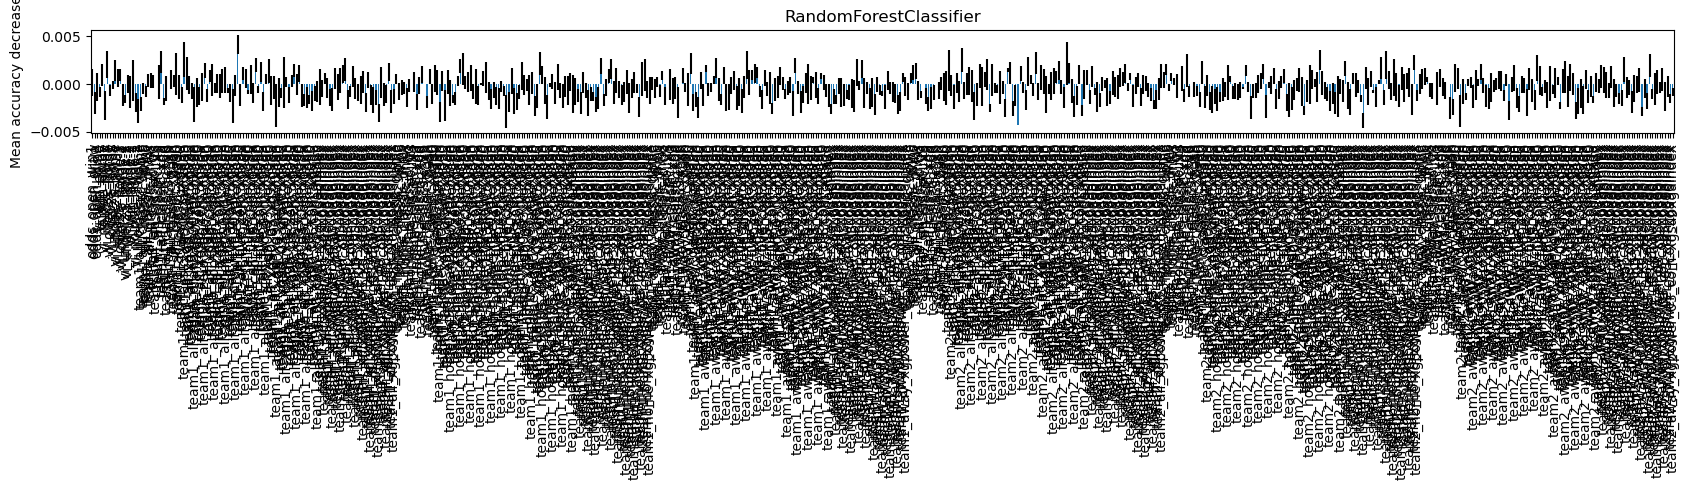

In [77]:
visualize_feature_importances(
    perm_imps_forest.importances_mean, 
    perm_imps_forest.importances_std, 'RandomForestClassifier'
)

Видно, что есть признаки, для которых `mean_accuracy_decrease` отрицательно. Т. е. Удаление этих признаков из датасета может повысить точность.

In [144]:
good_features = X_test.columns[perm_imps_forest.importances_mean + perm_imps_forest.importances_std > perm_imps_forest.importances_mean.max() * 0.3]

X_test_small, X_train_small = X_test[good_features], X_train[good_features]

X_test_small.shape, X_train_small.shape

((5882, 175), (47056, 175))

In [ ]:
forest = RandomForestClassifier(
    n_estimators=300, bootstrap=False,
    n_jobs=-1, max_features='log2',
    warm_start=True, random_state=42
)

forest.fit(X_train_small, y_train)

Accuracy:  0.3837130227813669
ROC AUC (macro):   0.5525012931411722


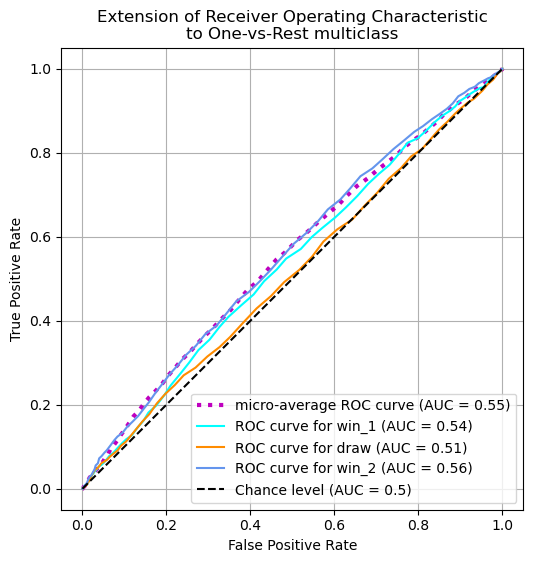

In [149]:
forest_results = test(forest, 'forest_1', X_test_small, y_test, groups_test)